<a href="https://colab.research.google.com/github/kkb0318/benkyokai/blob/main/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Install

In [ ]:
!apt-get install python-pydot
!pip install pydotplus

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-pyparsing
Suggested packages:
  python-pyparsing-doc
The following NEW packages will be installed:
  python-pydot python-pyparsing
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 71.7 kB of archives.
After this operation, 347 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-pyparsing all 2.2.0+dfsg1-2 [52.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pydot all 1.2.3-1 [19.6 kB]
Fetched 71.7 kB in 1s (58.2 kB/s)
Selecting previously unselected package python-pyparsing.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../python-pyparsing_2.2.0+d

## titanic dataset

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

The dataset consists of a training set and an evaluation set:

* `dftrain` and `y_train` are the *training set*—the data the model uses to learn.
* The model is tested against the *eval set*, `dfeval`, and `y_eval`.

For training you will use the following features:


<table>
  <tr>
    <th>Feature Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>sex</td>
    <td>Gender of passenger</td>
  </tr>
  <tr>
    <td>age</td>
    <td>Age of passenger</td>
  </tr>
    <tr>
    <td>n_siblings_spouses</td>
    <td>siblings and partners aboard</td>
  </tr>
    <tr>
    <td>parch</td>
    <td>of parents and children aboard</td>
  </tr>
    <tr>
    <td>fare</td>
    <td>Fare passenger paid.</td>
  </tr>
    <tr>
    <td>class</td>
    <td>Passenger's class on ship</td>
  </tr>
    <tr>
    <td>deck</td>
    <td>Which deck passenger was on</td>
  </tr>
    <tr>
    <td>embark_town</td>
    <td>Which town passenger embarked from</td>
  </tr>
    <tr>
    <td>alone</td>
    <td>If passenger was alone</td>
  </tr>
</table>

## Explore the data

Let's first preview some of the data and create summary statistics on the training set.

In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


There are 627 and 264 examples in the training and evaluation sets, respectively.

In [ ]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

The majority of passengers are in their 20's and 30's.

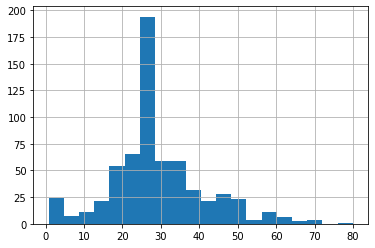

In [ ]:
dftrain.age.hist(bins=20)
plt.show()

There are approximately twice as male passengers as female passengers aboard.

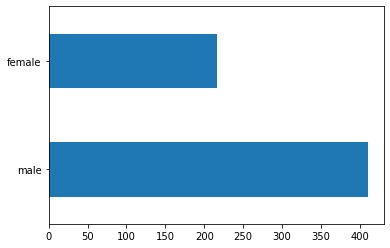

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

The majority of passengers were in the "third" class.

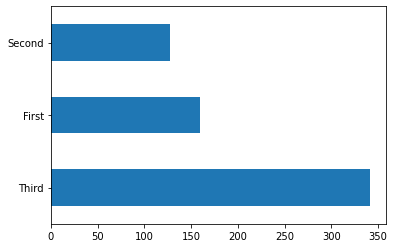

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

Most passengers embarked from Southampton.

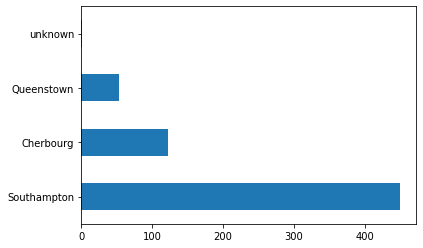

In [ ]:
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

Females have a much higher chance of surviving vs. males. This will clearly be a predictive feature for the model.

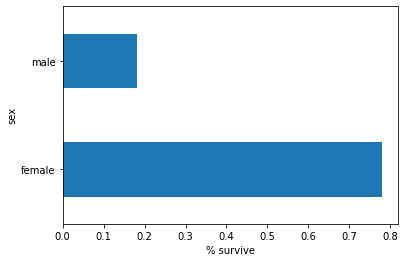

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

## Train and evaluate the model

### Preprocessing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
def make_input_fn(X):
  #print(X.isnull().sum())
  X = X.dropna()
  X["sex"] = X["sex"].map({"male":0,"female":1})
  X["alone"] = X["alone"].map({"n":0,"y":1})
  X = pd.get_dummies(X, columns=['embark_town'])
  X = pd.get_dummies(X, columns=['class'])
  X = pd.get_dummies(X, columns=['deck'])
  return X

In [ ]:
x_train = make_input_fn(dftrain)
x_eval = make_input_fn(dfeval)

In [ ]:
# 足りない列を追加
x_eval[x_train.columns.difference(x_eval.columns)]=0
x_eval

,sex,age,n_siblings_spouses,parch,fare,alone,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_unknown,class_First,class_Second,class_Third,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_unknown,deck_G
0,0,35.0,0,0,8.0500,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,0,54.0,0,0,51.8625,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
2,1,58.0,0,0,26.5500,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
3,1,55.0,0,0,16.0000,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
4,0,34.0,0,0,13.0000,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,1,25.0,0,1,26.0000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
260,0,33.0,0,0,7.8958,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
261,1,39.0,0,5,29.1250,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
262,0,27.0,0,0,13.0000,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


### Training

In [ ]:
clf = DecisionTreeClassifier(
    criterion='gini',   # 評価関数として何を使うか　ジニ係数(gini) or エントロピー(entropy)
    splitter='best', 
    max_depth=2, # 木の深さの最大値を指定（過学習抑制のため）
    min_samples_split=20, # 分割対象となるノードの最小サンプル数。min_samples_splitの数に達したノードはそれ以上分割しない
    min_samples_leaf=1, # 葉ノードに含まれる最小サンプル数。この数以下になるノードが存在しないように分割する
    min_weight_fraction_leaf=0, 
    max_features=None, 
    random_state=42, # 乱数シード
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight=None, 
    ccp_alpha=0.0
).fit(x_train, y_train)

In [ ]:
predicted = clf.predict(x_eval)

### evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score
print(confusion_matrix(y_eval,predicted))
print(precision_score(y_eval,predicted))

[[132  33]
 [ 35  64]]
0.6597938144329897


## Visualization

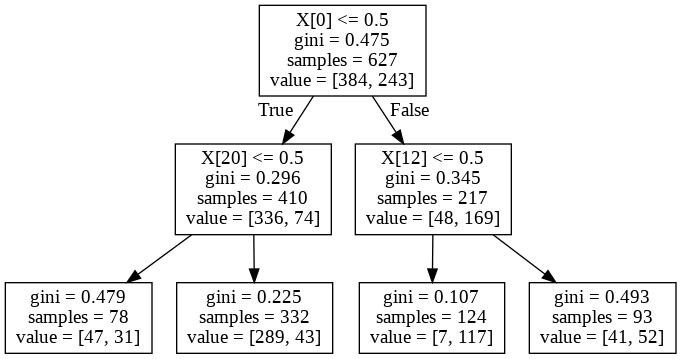

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())